In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# ==== instellingen ====
first_seconds = 10

In [3]:
# ==== inlezen ====
df = pd.read_csv(
    "../data/txt/ecg_paul_fixed.txt",
    sep=r"\t",                # tab-gescheiden
    decimal=",",              # komma als decimaalteken
    parse_dates=[[0, 1]],     # combineer datum + tijd in één kolom
    dayfirst=True,            # dd-MM-yyyy
    engine="python"
)

C:\Users\MSI\AppData\Local\Temp\ipykernel_67668\2627502401.py:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
C:\Users\MSI\AppData\Local\Temp\ipykernel_67668\2627502401.py:2: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S.%f format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df = pd.read_csv(


In [4]:
# header opschonen, hernoemen & index
df.columns = df.columns.str.strip().str.replace(r"\s+", " ", regex=True)
df.rename(columns={"yyyy-MM-dd_HH:mm:ss.ffffff": "timestamp"}, inplace=True)
df.set_index("timestamp", inplace=True)

In [5]:
# ==== basisleads controleren ====
req = ["Lead I (mV)", "Lead II (mV)"]
missing = [c for c in req if c not in df.columns]
if missing:
    raise ValueError(f"Kolommen ontbreken: {missing}. Beschikbaar: {list(df.columns)}")

In [6]:
# ==== alle 6 limb leads afleiden ====
df["Lead III (mV)"] = df["Lead II (mV)"] - df["Lead I (mV)"]
df["aVR (mV)"]      = -0.5 * (df["Lead I (mV)"] + df["Lead II (mV)"])
df["aVL (mV)"]      = df["Lead I (mV)"] - 0.5 * df["Lead II (mV)"]
df["aVF (mV)"]      = df["Lead II (mV)"] - 0.5 * df["Lead I (mV)"]

lead_cols = ["Lead I (mV)", "Lead II (mV)", "Lead III (mV)",
             "aVR (mV)", "aVL (mV)", "aVF (mV)"]

In [7]:
# ==== sample rate schatting uit timestamps ====
dts = df.index.to_series().diff().dropna().dt.total_seconds().values
if len(dts) == 0:
    raise ValueError("Onvoldoende rijen om sampling-interval te bepalen.")
dt = np.median(dts)
fs = 1.0 / dt
expected = int(round(first_seconds * fs))

In [8]:
# ==== exact 10 s selecteren ====
t0 = df.index[0]
mask = (df.index >= t0) & (df.index < t0 + pd.Timedelta(seconds=first_seconds))
df10 = df.loc[mask, lead_cols]

if len(df10) > expected:
    df10 = df10.iloc[:expected]

print(f"Schatting fs ≈ {fs:.3f} Hz | geselecteerd: {len(df10)} samples (verwacht ~{expected})")

Schatting fs ≈ 500.250 Hz | geselecteerd: 4877 samples (verwacht ~5003)


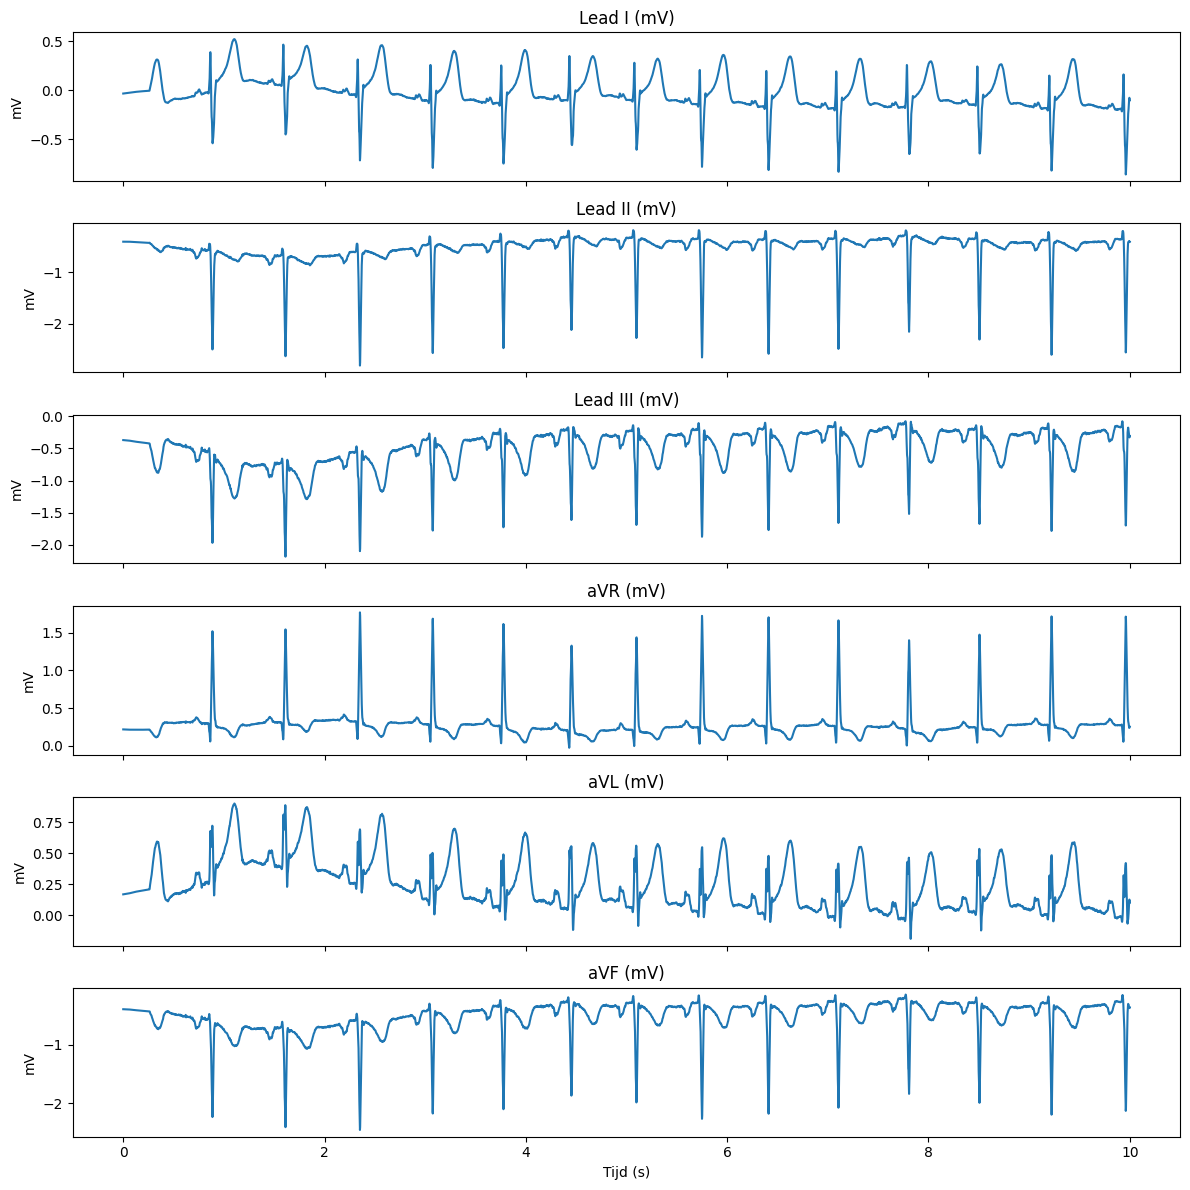

In [9]:
# ==== plotten: 6 leads in subplots ====
fig, axes = plt.subplots(6, 1, figsize=(12, 12), sharex=True)

t_sec = (df10.index - df10.index[0]).total_seconds()

for ax, col in zip(axes, lead_cols):
    ax.plot(t_sec, df10[col])
    ax.set_ylabel("mV")
    ax.set_title(col)

axes[-1].set_xlabel("Tijd (s)")
plt.tight_layout()
plt.show()